<div style="width:50%; float:left;">
    <img src="support_files/AIBS_banner.png" width="430" align="left">
</div>

<div style="width:50%; float:right;">
    <img src="support_files/Dipde_Nick_final.png" width="100" height="100" align="right">
</div>

<div style="width:100%; float:left;">
    <hr>
</div>



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h1>Example: Recurrent</h1>
<p> In this example, two internal dipde populations (one labeled "excitatory" and the other "inhibitory") receive from a several external populations. Try adjusting the strength of the recurrent connections, and see how this changes the steady state firing rates of the populations.  The parameters `dv` and `dt` control the fundamental tradeoff between the accuracy of the simulation and its execution time.  You might find it helpful to consider smaller values of these parameters at first, and then try reducing them once you have set the recurrent connection weights.

In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
%matplotlib notebook
import dipde
assert dipde.__version__ == '0.2.1'
from IPython.display import display
import matplotlib.pyplot as plt
import ipywidgets as ipw
import logging
logging.disable(logging.CRITICAL)
from dipde.interfaces.jupyter import ZMQIntSlider, wrap_widget, ProgressBar
from IPython.display import display
import time

<IPython.core.display.Javascript object>


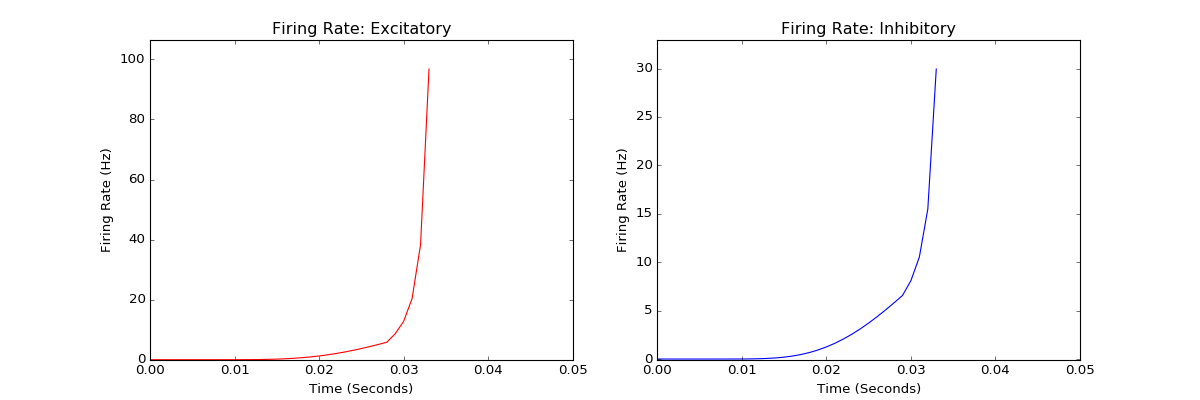

In [4]:
t0 = 0.
dv = .001
dt = .001
v_min = -.01
v_max = .02
tf = .5
tau_m=.02
weights=.001
bgfr = 800
window_size = .05

def slow_callback(n):
    time.sleep(.05)

b = dipde.ExternalPopulation(bgfr)
ie = dipde.InternalPopulation(v_min=v_min, tau_m=tau_m, v_max=v_max, dv=dv, update_method='approx')
ii = dipde.InternalPopulation(v_min=v_min, tau_m=tau_m, v_max=v_max, dv=dv, update_method='approx')

b_ie = dipde.Connection(b, ie, 1, weights=weights)
b_ii = dipde.Connection(b, ii, 1, weights=weights)

initial_nsyn = 25
max_nsyn = 2*initial_nsyn
ie_ie = wrap_widget(dipde.Connection(ie, ie, 1, weights=weights), ZMQIntSlider(5556, display=True, value=initial_nsyn, min=1, max=max_nsyn, continuous_update=False, description='ee'), 'nsyn') 
ie_ii = wrap_widget(dipde.Connection(ie, ii, 1, weights=weights), ZMQIntSlider(5557, display=True, value=initial_nsyn, min=1, max=max_nsyn, continuous_update=False, description='ei'), 'nsyn') 
ii_ie = wrap_widget(dipde.Connection(ii, ie, 1, weights=-weights), ZMQIntSlider(5558, display=True, value=initial_nsyn, min=1, max=max_nsyn, continuous_update=False, description='ie'), 'nsyn') 
ii_ii = wrap_widget(dipde.Connection(ii, ii, 1, weights=-weights), ZMQIntSlider(5559, display=True, value=initial_nsyn, min=1, max=max_nsyn, continuous_update=False, description='ii'), 'nsyn') 



network = dipde.Network([ie, ii, b], [b_ie, b_ii, ie_ie, ie_ii, ii_ie, ii_ii], update_callback=slow_callback, progress=ProgressBar())

fig, axes = plt.subplots(1,2, figsize=(15,5))
ie.plot(ax=axes[0], ylim=(0,30), color='r', show=False, title='Firing Rate: Excitatory', xlim=(0,window_size))
ii.plot(ax=axes[1], ylim=(0,30), color='b', show=True, title='Firing Rate: Inhibitory', xlim=(0,window_size))

def plot_callback(s):
    
    for pi in [0,1]:
    
        p = s.network.population_list[pi]
        ax = axes[pi]
        window_points = int(window_size/dt)

        if len(p.t_record) < window_points:

            t_vals = p.t_record
            y_vals = p.firing_rate_record
        else:
            t_vals = p.t_record[-window_points:]
            y_vals = p.firing_rate_record[-window_points:]

        ax.lines[0].set_xdata(t_vals)
        ax.lines[0].set_ydata(y_vals)
        if t_vals[-1] < window_size:
            t_max = window_size
        else:
            t_max = t_vals[-1]*1.05

        ax.set_xlim((t_vals[0],t_max))
        ax.set_ylim((-.1,max(20, max(y_vals)*1.1)))

    fig.canvas.draw()


simulation_configuration = dipde.SimulationConfiguration(dt, tf, t0=t0, checkpoint_period=.2)
simulation = dipde.Simulation(network=network, simulation_configuration=simulation_configuration, checkpoint_callback=plot_callback)
simulation.start()

